### Read through each step and run the code in order.




### 0 - Includes and constants
    
Display original image in either BGR | RGB | HSV

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from copy import deepcopy

# Read the image
IMAGE_FILE = cv2.imread("sample_maze_2.jpg")

# Read the image and rotate for 180 degrees. 
# IMAGE_FILE = cv2.rotate(cv2.imread("maze.jpg"), cv2.ROTATE_180)



# Parameters for the grid
rows = 5  # Number of rows of nodes
cols = 9  # Number of columns of nodes
node_radius = 5  # Radius of the nodes 


# Start and end position
start_position = [0, 0, "W"]
end_position = [0, 8]






# #change between RGB | BGR | HSV
# display_type = "RGB"


# if(display_type == "RGB"):
#     original_image = cv2.cvtColor(IMAGE_FILE, cv2.COLOR_BGR2RGB)
# elif(display_type == "BGR"):
#     original_image = IMAGE_FILE
# elif(display_type == "HSV"):
#     original_image = cv2.cvtColor(IMAGE_FILE, cv2.COLOR_BGR2HSV)

# plt.imshow(original_image)
# plt.show()

### 1 - Crop image

Use mouse to select cropped area, hit 's' to save the image. Hit 'esc' to exit.

Crop ON the edge or INSIDE the edge.

In [ ]:
# Resize the image to half its original size
height, width = IMAGE_FILE.shape[:2]
original_image = cv2.resize(IMAGE_FILE, (width // 2, height // 2))

# Mouse callback function for selecting the crop area
def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = original_image.copy()
        cv2.rectangle(img_copy, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow('Maze', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        img_copy = original_image.copy()
        cv2.rectangle(img_copy, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow('Maze', img_copy)

# Initialize variables
start_point = (0, 0)
end_point = (0, 0)
selecting = False

# Create a window and set the mouse callback
cv2.namedWindow('Maze')
cv2.setMouseCallback('Maze', mouse_callback)

# Display the image
cv2.imshow('Maze', original_image)

# Wait for key press
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('s'):  # Press 's' to save the cropped image
        if start_point != end_point:
            # Get the region of interest
            roi = original_image[start_point[1]:end_point[1], start_point[0]:end_point[0]]
            # Save the cropped image
            cv2.imwrite('cropped_maze.jpg', roi)
            print("Image saved as 'cropped_maze.jpg'")
        cv2.destroyAllWindows()
        break
    elif key == 27:  # Press 'Esc' to exit without saving
        cv2.destroyAllWindows()
        break

# Load and display the cropped image using matplotlib
cropped_image = cv2.imread('cropped_maze.jpg')
if cropped_image is not None:
    # Convert BGR to RGB
    cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    plt.imshow(cropped_image_rgb)
    plt.title('Cropped Maze')
    plt.show()


### 2 - HSV picker

Find the low and high HSV values in the selected area. 

DO NOT include any area with walls, standoffs or holes. 

Select 3 areas and hit 's' to record average low and high HSV values. Hit 'esc' to exit.

In [ ]:
# Load the image
cropped_maze = cv2.imread("cropped_maze.jpg")

# Initialize variables
start_point = (0, 0)
end_point = (0, 0)
selecting = False
regions = []  # List to store selected regions
MAX_AREAS = 3

# Function to calculate the minimum and maximum HSV values of a region
def calculate_hsv_values(img, start_point, end_point):
    # Ensure the start and end points are within the image bounds
    start_x, start_y = start_point
    end_x, end_y = end_point
    if start_x > end_x or start_y > end_y or start_x < 0 or start_y < 0 or end_x > img.shape[1] or end_y > img.shape[0]:
        print("Selected area is out of bounds.")
        return None, None

    # Get the region of interest
    roi = img[start_y:end_y, start_x:end_x]
    if roi.size == 0:
        print("Selected area is empty.")
        return None, None
    
    # Convert the region to HSV
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    min_hsv = np.min(hsv_roi.reshape(-1, 3), axis=0)
    max_hsv = np.max(hsv_roi.reshape(-1, 3), axis=0)
    
    return min_hsv, max_hsv

# Mouse callback function
def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, regions
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = cropped_maze.copy()
        for region in regions:
            cv2.rectangle(img_copy, region[0], region[1], (0, 255, 0), 2)
        cv2.rectangle(img_copy, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow('Cropped Maze', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        if len(regions) >= MAX_AREAS:
            regions.pop(0)  # Remove the earliest area if the limit is exceeded
        regions.append((start_point, end_point))
        img_copy = cropped_maze.copy()
        for region in regions:
            cv2.rectangle(img_copy, region[0], region[1], (0, 255, 0), 2)
        cv2.imshow('Cropped Maze', img_copy)
        

# Create a window and set the mouse callback
cv2.namedWindow('Cropped Maze')
cv2.setMouseCallback('Cropped Maze', mouse_callback)

# Display the image
cv2.imshow('Cropped Maze', cropped_maze)

# Wait for key press
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('s'):  # Press 's' to save the HSV values
        if regions:
            all_min_hsv = []
            all_max_hsv = []
            for start_point, end_point in regions:
                min_hsv, max_hsv = calculate_hsv_values(cropped_maze, start_point, end_point)
                if min_hsv is not None and max_hsv is not None:
                    all_min_hsv.append(min_hsv)
                    all_max_hsv.append(max_hsv)
            
            if all_min_hsv and all_max_hsv:
                overall_min_hsv = np.round(np.min(all_min_hsv, axis=0), 2)
                overall_max_hsv = np.round(np.max(all_max_hsv, axis=0), 2)
                
                print(f"low_hsv = [{overall_min_hsv[0]}, {overall_min_hsv[1]}, {overall_min_hsv[2]}]")
                print(f"high_hsv = [{overall_max_hsv[0]}, {overall_max_hsv[1]}, {overall_max_hsv[2]}]")
            else:
                print("No valid regions selected.")
        cv2.destroyAllWindows()
        break
    elif key == 27:  # Press 'Esc' to exit without saving
        cv2.destroyAllWindows()
        break

### 3 - Create mask based on HSV values


In [ ]:
mask_adjust = -15

# Load the image
image = cv2.imread("cropped_maze.jpg")
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Create the mask
mask = cv2.inRange(image_hsv, overall_min_hsv + mask_adjust, overall_max_hsv - mask_adjust)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.show()

### 4 - Image processing

Tune it using the four variables. 

In [ ]:
# Parameters for erosion and dilation
erosion_kernel_size = (3, 3)  # Size of the kernel for erosion
dilation_kernel_size = (3, 3)  # Size of the kernel for dilation
iterations_erosion = 2  # Number of erosion iterations
iterations_dilation = 2  # Number of dilation iterations

erosion_kernel = np.ones(erosion_kernel_size, np.uint8)
dilation_kernel = np.ones(dilation_kernel_size, np.uint8)

result = mask

# result = cv2.bitwise_not(mask)

# Perform erosion
result = cv2.erode(result, erosion_kernel, iterations=iterations_erosion)

# Perform dilation
result = cv2.dilate(result, dilation_kernel, iterations=iterations_dilation)

# Save the result image
cv2.imwrite('mask.jpg', result)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(result, cmap='gray')
plt.show()


### 5 - Class for BFS

In [2]:
class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        self.nodes[node_id] = Node(node_id, x, y)
        self.edges[node_id] = []

    def add_edge(self, node_id1, node_id2, weight):
        self.edges[node_id1].append((node_id2, weight))
        self.edges[node_id2].append((node_id1, weight))

    def remove_edge(self, node_id1, node_id2):
        self.edges[node_id1] = [(nid, w) for nid, w in self.edges[node_id1] if nid != node_id2]
        self.edges[node_id2] = [(nid, w) for nid, w in self.edges[node_id2] if nid != node_id1]
    
    def remove_node(self, node_id):
        # Remove edges connected to the node
        if node_id in self.edges:
            for nid in self.edges[node_id]:
                self.remove_edge(node_id, nid[0])
            del self.edges[node_id]
        
        # Remove the node itself
        if node_id in self.nodes:
            del self.nodes[node_id]

            
    def get_nodes(self):
        return self.nodes.keys()
    
    def get_edge_weight(self, node_id1, node_id2):
        for nid, w in self.edges[node_id1]:
            if nid == node_id2:
                return w
        return None

### 6 - Grid and BFS Path planning

Click and drag to select the grid area.

Define starting position as [x, y, heading]. Ending position as [x, y]

Generate the path and display in blue.

In [ ]:
graph = Graph()

# Variable for path width
path_width = 3 

# Parameters for BFS
start_node = (start_position[0], start_position[1])
end_node = (end_position[0], end_position[1])

# Load the mask image (from the previous script)
# result_rgb = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)

# Load the mask image (only use this during debug)
mask = cv2.imread("mask_2.jpg")
result_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
result = result_rgb.copy()


def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, selected_area
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = result_rgb.copy()
        cv2.rectangle(img_copy, start_point, end_point, (255, 0, 0), 2)
        cv2.imshow('Select Grid Area', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        selected_area = (start_point, end_point)
        print(f"Selected area: {selected_area}")

def create_grid(image_rgb, area, rows, cols):
    (start_x, start_y), (end_x, end_y) = area
    # Calculate grid cell size
    cell_width = (end_x - start_x) // (cols - 1)
    cell_height = (end_y - start_y) // (rows - 1)
    
    grid_image = image_rgb.copy()
    
    # Draw grid nodes as blue dots and create graph nodes
    for i in range(rows):
        for j in range(cols):
            x = start_x + j * cell_width
            y = start_y + i * cell_height
            cv2.circle(grid_image, (x, y), node_radius, (255, 0, 0), -1)
            graph.add_node((i, j), x, y)

    
    # Add edges if all parallel lines in the path are all white
    # for i in range(rows):
    #     for j in range(cols):
    #         x1 = start_x + j * cell_width
    #         y1 = start_y + i * cell_height

    #         # Check vertical edges
    #         if j < cols - 1:
    #             x2 = x1 + cell_width
    #             vertical_path = result[y1-path_width//2:y1+path_width//2, x1:x2]
    #             if np.all(vertical_path == 255):
    #                 graph.add_edge((i, j), (i, j + 1), 1)
    #                 cv2.line(grid_image, (x1, y1), (x2, y1), (0, 255, 0), 1)

    #         # Check horizontal edges
    #         if i < rows - 1:
    #             y2 = y1 + cell_height
    #             horizontal_path = result[y1:y2, x1-path_width//2:x1+path_width//2]
    #             if np.all(horizontal_path == 255):
    #                 graph.add_edge((i, j), (i + 1, j), 1)
    #                 cv2.line(grid_image, (x1, y1), (x1, y2), (0, 255, 0), 1)


    # Add edges if any parallel lines in the path are all white
    for i in range(rows):
        for j in range(cols):
            x1 = start_x + j * cell_width
            y1 = start_y + i * cell_height

            # Check vertical edges
            if j < cols - 1:
                x2 = x1 + cell_width
                vertical_clear = False
                for k in range(-path_width // 2, path_width // 2 + 1):
                    if y1 + k < 0 or y1 + k >= result.shape[0]:  # Boundary check
                        continue
                    vertical_path = result[y1 + k, x1:x2]
                    if np.all(vertical_path == 255):
                        vertical_clear = True
                        break
                if vertical_clear:
                    graph.add_edge((i, j), (i, j + 1), 1)
                    cv2.line(grid_image, (x1, y1), (x2, y1), (0, 255, 0), 1)

            # Check horizontal edges
            if i < rows - 1:
                y2 = y1 + cell_height
                horizontal_clear = False
                for k in range(-path_width // 2, path_width // 2 + 1):
                    if x1 + k < 0 or x1 + k >= result.shape[1]:  # Boundary check
                        continue
                    horizontal_path = result[y1:y2, x1 + k]
                    if np.all(horizontal_path == 255):
                        horizontal_clear = True
                        break
                if horizontal_clear:
                    graph.add_edge((i, j), (i + 1, j), 1)
                    cv2.line(grid_image, (x1, y1), (x1, y2), (0, 255, 0), 1)

    
    return grid_image, graph

def bfs_pathfinding(graph, start_node, end_node):
    queue = deque([start_node])
    came_from = {start_node: None}
    
    while queue:
        current = queue.popleft()
        if current == end_node:
            break
        
        for neighbor, _ in graph.edges.get(current, []):
            if neighbor not in came_from:
                queue.append(neighbor)
                came_from[neighbor] = current
    
    # Reconstruct path
    path = []
    current = end_node
    while current is not None:
        path.append(current)
        current = came_from[current]
    
    path.reverse()
    return path

# Create a window and set the mouse callback
cv2.namedWindow('Select Grid Area')
cv2.setMouseCallback('Select Grid Area', mouse_callback)

# Display the mask image for selecting area
cv2.imshow('Select Grid Area', result_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()

if 'selected_area' in globals():
    grid_image, graph = create_grid(result_rgb, selected_area, rows, cols)
    
    # Find and highlight the path
    path = bfs_pathfinding(graph, start_node, end_node)
    
    # Draw the path and nodes
    for node in path:
        x, y = graph.nodes[node].get_point()
        cv2.circle(grid_image, (x, y), node_radius, (0, 0, 255), -1)
    
    # Draw edges on the path
    for i in range(len(path) - 1):
        x1, y1 = graph.nodes[path[i]].get_point()
        x2, y2 = graph.nodes[path[i + 1]].get_point()
        cv2.line(grid_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    # Highlight start and end nodes
    start_x, start_y = graph.nodes[start_node].get_point()
    end_x, end_y = graph.nodes[end_node].get_point()
    cv2.circle(grid_image, (start_x, start_y), node_radius, (0, 0, 255), -1)  
    cv2.circle(grid_image, (end_x, end_y), node_radius, (0, 0, 255), -1)  
    cv2.putText(grid_image, 'S', (start_x + node_radius, start_y - node_radius), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv2.putText(grid_image, 'E', (end_x + node_radius, end_y - node_radius), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    
    # Display the final grid image with nodes, edges, and path
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_image)
    plt.title('Grid with Nodes, Edges, and Path')
    plt.show()
else:
    print("No area selected. Please run the selection process again.")

### Testing section (Don't run)

In [ ]:
graph = Graph()

# Variable for path width
path_width = 3 

# Parameters for BFS
start_node = (start_position[0], start_position[1])
end_node = (end_position[0], end_position[1])

# Load the mask image (from the previous script)
# result_rgb = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)

# Load the mask image (only use this during debug)
mask = cv2.imread("mask_2.jpg")
result_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
result = result_rgb.copy()

def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, selected_area
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = result_rgb.copy()
        cv2.rectangle(img_copy, start_point, end_point, (255, 0, 0), 2)
        cv2.imshow('Select Grid Area', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        selected_area = (start_point, end_point)
        print(f"Selected area: {selected_area}")

def create_grid(image_rgb, area, rows, cols):
    (start_x, start_y), (end_x, end_y) = area
    # Calculate grid cell size
    cell_width = (end_x - start_x) // (cols - 1)
    cell_height = (end_y - start_y) // (rows - 1)
    
    grid_image = image_rgb.copy()
    edges_image = image_rgb.copy()

    # Draw grid nodes as blue dots and create graph nodes
    for i in range(rows):
        for j in range(cols):
            x = start_x + j * cell_width
            y = start_y + i * cell_height
            cv2.circle(grid_image, (x, y), node_radius, (255, 0, 0), -1)
            cv2.circle(edges_image, (x, y), node_radius, (255, 0, 0), -1)
            graph.add_node((i, j), x, y)

    # Add edges if any parallel lines in the path are all white
    for i in range(rows):
        for j in range(cols):
            x1 = start_x + j * cell_width
            y1 = start_y + i * cell_height

            # Check vertical edges
            if j < cols - 1:
                x2 = x1 + cell_width
                vertical_clear = False
                for k in range(-path_width // 2, path_width // 2 + 1):
                    if y1 + k < 0 or y1 + k >= result.shape[0]:  # Boundary check
                        continue
                    vertical_path = result[y1 + k, x1:x2]
                    if np.all(vertical_path == 255):
                        vertical_clear = True
                        break
                if vertical_clear:
                    graph.add_edge((i, j), (i, j + 1), 1)
                    cv2.line(grid_image, (x1, y1), (x2, y1), (0, 255, 0), 1)
                    cv2.line(edges_image, (x1, y1), (x2, y1), (0, 255, 0), 1)

            # Check horizontal edges
            if i < rows - 1:
                y2 = y1 + cell_height
                horizontal_clear = False
                for k in range(-path_width // 2, path_width // 2 + 1):
                    if x1 + k < 0 or x1 + k >= result.shape[1]:  # Boundary check
                        continue
                    horizontal_path = result[y1:y2, x1 + k]
                    if np.all(horizontal_path == 255):
                        horizontal_clear = True
                        break
                if horizontal_clear:
                    graph.add_edge((i, j), (i + 1, j), 1)
                    cv2.line(grid_image, (x1, y1), (x1, y2), (0, 255, 0), 1)
                    cv2.line(edges_image, (x1, y1), (x1, y2), (0, 255, 0), 1)

    return grid_image, edges_image, graph

def bfs_pathfinding(graph, start_node, end_node):
    queue = deque([start_node])
    came_from = {start_node: None}
    
    while queue:
        current = queue.popleft()
        if current == end_node:
            break
        
        for neighbor, _ in graph.edges.get(current, []):
            if neighbor not in came_from:
                queue.append(neighbor)
                came_from[neighbor] = current
    
    # Reconstruct path
    path = []
    current = end_node
    while current is not None:
        path.append(current)
        current = came_from[current]
    
    path.reverse()
    return path

# Create a window and set the mouse callback
cv2.namedWindow('Select Grid Area')
cv2.setMouseCallback('Select Grid Area', mouse_callback)

# Display the mask image for selecting area
cv2.imshow('Select Grid Area', result_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()

if 'selected_area' in globals():
    grid_image, edges_image, graph = create_grid(result_rgb, selected_area, rows, cols)
    
    # Find and highlight the path
    path = bfs_pathfinding(graph, start_node, end_node)
    
    # Draw the path and nodes
    for node in path:
        x, y = graph.nodes[node].get_point()
        cv2.circle(grid_image, (x, y), node_radius, (0, 0, 255), -1)
    
    # Draw edges on the path
    for i in range(len(path) - 1):
        x1, y1 = graph.nodes[path[i]].get_point()
        x2, y2 = graph.nodes[path[i + 1]].get_point()
        cv2.line(grid_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    # Highlight start and end nodes
    start_x, start_y = graph.nodes[start_node].get_point()
    end_x, end_y = graph.nodes[end_node].get_point()
    cv2.circle(grid_image, (start_x, start_y), node_radius, (0, 0, 255), -1)  
    cv2.circle(grid_image, (end_x, end_y), node_radius, (0, 0, 255), -1)  
    cv2.putText(grid_image, 'S', (start_x + node_radius, start_y - node_radius), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv2.putText(grid_image, 'E', (end_x + node_radius, end_y - node_radius), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    
    # Display the image with only nodes and edges
    plt.figure(figsize=(10, 10))
    plt.imshow(edges_image)
    plt.title('Grid with Nodes and Edges Only')
    plt.show()
    
    # Display the final grid image with nodes, edges, and path
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_image)
    plt.title('Grid with Nodes, Edges, and Path')
    plt.show()
else:
    print("No area selected. Please run the selection process again.")

### 7 - Generate chain command

Default turning around using "rr"

In [ ]:
def generate_robot_commands(path, start_position, end_position):
    directions = ["N", "E", "S", "W"]
    delta = {
        ("N", "E"): 'r',
        ("N", "W"): 'l',
        ("E", "N"): 'l',
        ("E", "S"): 'r',
        ("S", "E"): 'l',
        ("S", "W"): 'r',
        ("W", "N"): 'r',
        ("W", "S"): 'l'
    }
    
    # To handle turning around
    turn_around = {
        "N": "S",
        "E": "W",
        "S": "N",
        "W": "E"
    }
    
    # Initialize variables
    commands = []
    current_position = start_position[:]
    current_direction = start_position[2]
    
    # Process each node in the path
    for i in range(1, len(path)):
        prev_node = path[i - 1]
        curr_node = path[i]
        
        # Determine movement direction
        if curr_node[0] > prev_node[0]:
            move = 'f'
            new_direction = 'S'
        elif curr_node[0] < prev_node[0]:
            move = 'f'
            new_direction = 'N'
        elif curr_node[1] > prev_node[1]:
            move = 'f'
            new_direction = 'E'
        elif curr_node[1] < prev_node[1]:
            move = 'f'
            new_direction = 'W'
        
        # Handle turning around
        if new_direction == turn_around[current_direction]:
            commands.extend(['r', 'r'])  # Turn around
            current_direction = new_direction
        
        # Add direction changes
        elif new_direction != current_direction:
            turn = delta[(current_direction, new_direction)]
            commands.append(turn)
            current_direction = new_direction
        
        # Add forward movement
        if move == 'f':
            commands.append('f')
    
    # Convert the list of commands to a string
    return ''.join(commands)

commands = generate_robot_commands(path, start_position, end_position)
print("Generated commands:", commands)

### 6.2 - Continue planning

Selected area: ((44, 40), (709, 384))


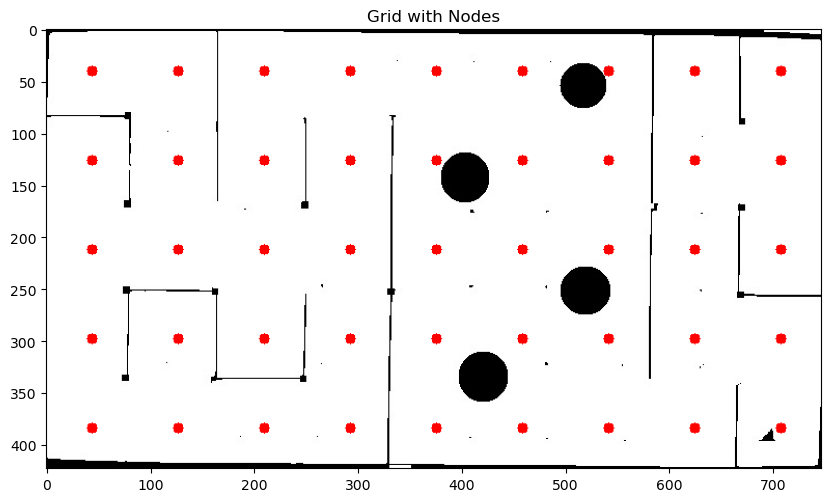

In [4]:
graph = Graph()

# Variable for path width
path_width = 3 

# Load the mask image (from the previous script)
# result_rgb = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)

# Load the mask image (only use this during debug)
mask = cv2.imread("mask_2.jpg")
result_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
result = result_rgb.copy()

def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, selected_area
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = result_rgb.copy()
        cv2.rectangle(img_copy, start_point, end_point, (255, 0, 0), 2)
        cv2.imshow('Select Grid Area', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        selected_area = (start_point, end_point)
        print(f"Selected area: {selected_area}")

def create_grid(image_rgb, area, rows, cols):
    (start_x, start_y), (end_x, end_y) = area
    # Calculate grid cell size
    cell_width = (end_x - start_x) // (cols - 1)
    cell_height = (end_y - start_y) // (rows - 1)
    
    grid_image = image_rgb.copy()

    # Draw grid nodes as blue dots and create graph nodes
    for i in range(rows):
        for j in range(cols):
            x = start_x + j * cell_width
            y = start_y + i * cell_height
            cv2.circle(grid_image, (x, y), node_radius, (255, 0, 0), -1)
            graph.add_node((i, j), x, y)

    return grid_image, cell_width, cell_height

# Create a window and set the mouse callback
cv2.namedWindow('Select Grid Area')
cv2.setMouseCallback('Select Grid Area', mouse_callback)

# Display the mask image for selecting area
cv2.imshow('Select Grid Area', result_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()

if 'selected_area' in globals():
    grid_image, cell_width, cell_height = create_grid(result_rgb, selected_area, rows, cols)
    
    # Display the final grid image with nodes
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_image)
    plt.title('Grid with Nodes')
    plt.show()
else:
    print("No area selected. Please run the selection process again.")

### Mark obstacle area

Selected area: ((339, 12), (581, 401))


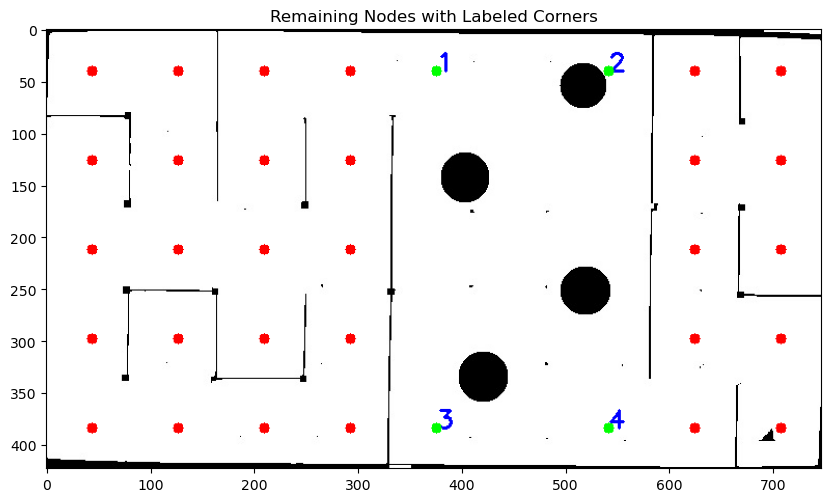

In [5]:
# Function to handle mouse callback for selecting area
def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, selected_area
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = grid_image.copy()
        cv2.rectangle(img_copy, start_point, end_point, (255, 0, 0), 2)
        cv2.imshow('Select Grid Area', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        selected_area = (start_point, end_point)
        print(f"Selected area: {selected_area}")

# Create a window and set the mouse callback
cv2.namedWindow('Select Grid Area')
cv2.setMouseCallback('Select Grid Area', mouse_callback)

# Display the grid image for selecting area
cv2.imshow('Select Grid Area', grid_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

if 'selected_area' in globals():
    (start_x, start_y), (end_x, end_y) = selected_area
    
    # Identify corner nodes
    def distance(point1, point2):
        return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5
    
    nodes_within_area = []
    for node in graph.nodes.values():
        x, y = node.get_point()
        if start_x <= x <= end_x and start_y <= y <= end_y:
            nodes_within_area.append((x, y))

    if len(nodes_within_area) < 4:
        print("Selected area does not contain enough nodes. Please select a larger area.")
    else:
        # Sort nodes by their positions to find corners
        top_left = min(nodes_within_area, key=lambda point: (point[1], point[0]))
        bottom_right = max(nodes_within_area, key=lambda point: (point[1], point[0]))
        top_right = max(nodes_within_area, key=lambda point: (point[0] - top_left[0] + bottom_right[1] - point[1]))
        bottom_left = min(nodes_within_area, key=lambda point: (point[0] - top_left[0] + bottom_right[1] - point[1]))

        corners = [top_left, top_right, bottom_left, bottom_right]
        
        # Remove nodes within the selected area except for the corners
        remaining_nodes = []
        for node in graph.nodes.values():
            x, y = node.get_point()
            if (start_x <= x <= end_x and start_y <= y <= end_y):
                if (x, y) not in corners:
                    continue
            remaining_nodes.append((x, y))
        
        # Create a copy of the original result image
        result_with_nodes = result_rgb.copy()
        
        # Draw the remaining nodes on the result image
        for (x, y) in remaining_nodes:
            cv2.circle(result_with_nodes, (x, y), 5, (255, 0, 0), -1)
        
        # Draw and label the corners
        labels = ['1', '2', '3', '4']
        for (x, y), label in zip(corners, labels):
            cv2.putText(result_with_nodes, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
            cv2.circle(result_with_nodes, (x, y), 5, (0, 255, 0), -1)
        
        # Display the result image with the remaining nodes and labeled corners
        plt.figure(figsize=(10, 10))
        plt.imshow(result_with_nodes)
        plt.title('Remaining Nodes with Labeled Corners')
        plt.show()
else:
    print("No area selected. Please run the selection process again.")

### Generate more nodes for the area

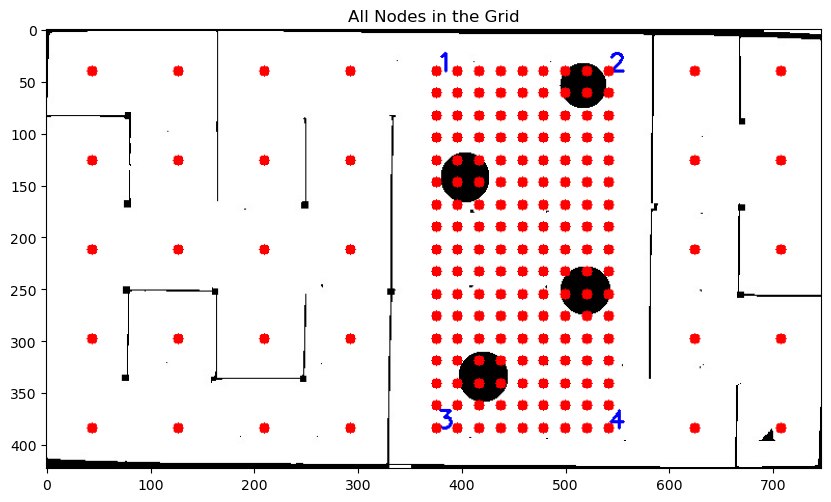

In [6]:
obstacle_graph = graph

# Define new grid parameters
obstacle_area_rows = 17
obstacle_area_cols = 9

# Define function to calculate distance between two points
def distance(point1, point2):
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

# Calculate cell width and height for the new grid
width = distance(top_left, top_right)
height = distance(top_left, bottom_left)
cell_width = width / (obstacle_area_cols - 1)
cell_height = height / (obstacle_area_rows - 1)

# Create a new image to display the new grid
new_grid_image = result_rgb.copy()

# Add new nodes to the obstacle_graph and draw them
for i in range(obstacle_area_rows):
    for j in range(obstacle_area_cols):
        x = int(top_left[0] + j * cell_width)
        y = int(top_left[1] + i * cell_height)
        cv2.circle(new_grid_image, (x, y), 5, (0, 255, 255), -1)  # Draw new nodes as yellow dots
        
        # Add new node to the obstacle_graph
        obstacle_graph.add_node((len(obstacle_graph.nodes) + i * obstacle_area_cols + j), x, y)

# Draw the corners and label them
corners = [top_left, top_right, bottom_left, bottom_right]
labels = ['1', '2', '3', '4']
for (x, y), label in zip(corners, labels):
    cv2.putText(new_grid_image, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv2.circle(new_grid_image, (x, y), 5, (0, 0, 255), -1)

# Draw all nodes on the image
for node_id, node in obstacle_graph.nodes.items():
    x, y = node.get_point()
    cv2.circle(new_grid_image, (x, y), 5, (255, 0, 0), -1)  # Draw existing nodes as red dots

# Display the final image with all nodes
plt.figure(figsize=(10, 10))
plt.imshow(new_grid_image)
plt.title('All Nodes in the Grid')
plt.show()

### Remove obstacle cells

Selected area: (356, 98), (448, 196)
Selected area: (468, 22), (558, 118)
Selected area: (474, 205), (557, 289)
Selected area: (361, 298), (469, 390)


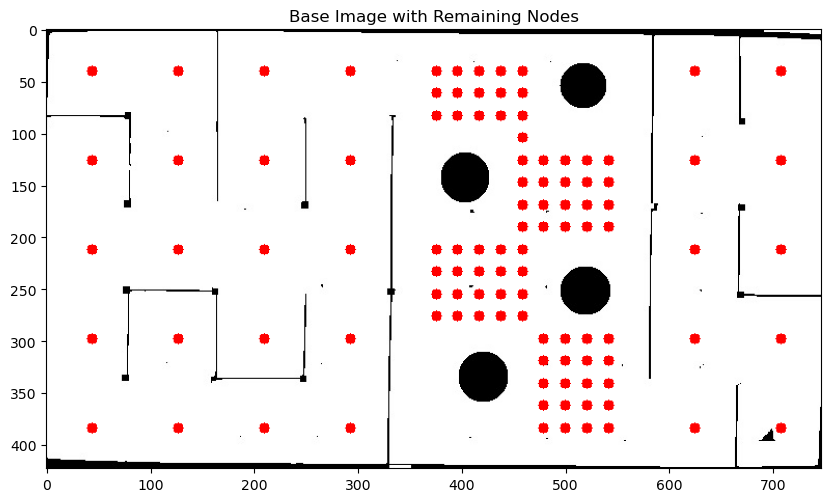

In [7]:
# Assuming obstacle_graph is your original graph object
clean_graph = deepcopy(obstacle_graph)
clean_grid_image = new_grid_image.copy()

# Initialize global variables for mouse callback
selecting = False
start_point = None
end_point = None
selected_areas = []

def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = clean_grid_image.copy()
        cv2.rectangle(img_copy, start_point, end_point, (255, 0, 0), 2)
        cv2.imshow('Select Area', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        selected_areas.append((start_point, end_point))  # Store the selected area
        cv2.rectangle(clean_grid_image, start_point, end_point, (255, 0, 0), 2)
        cv2.imshow('Select Area', clean_grid_image)
        print(f"Selected area: {start_point}, {end_point}")

def remove_nodes_in_areas(areas):
    for area in areas:
        start_point, end_point = area
        x1, y1 = start_point
        x2, y2 = end_point

        nodes_to_remove = []
        for node_id, node in clean_graph.nodes.items():
            x, y = node.get_point()
            if x1 <= x <= x2 and y1 <= y <= y2:
                nodes_to_remove.append(node_id)

        for node_id in nodes_to_remove:
            clean_graph.remove_node(node_id)

    # Display the base image with remaining nodes
    display_base_image_with_nodes()

def display_base_image_with_nodes():
    base_image_with_nodes = result_rgb.copy()
    for node_id, node in clean_graph.nodes.items():
        x, y = node.get_point()
        cv2.circle(base_image_with_nodes, (x, y), node_radius, (255, 0, 0), -1)  # Draw remaining nodes as red dots

    # Display the final base image with all remaining nodes
    plt.figure(figsize=(10, 10))
    plt.imshow(base_image_with_nodes)
    plt.title('Base Image with Remaining Nodes')
    plt.show()

# Display the new grid image and set the mouse callback
cv2.namedWindow('Select Area')
cv2.setMouseCallback('Select Area', mouse_callback)

# Show the new grid image
cv2.imshow('Select Area', clean_grid_image)

while True:
    key = cv2.waitKey(0)  # Wait for a key press
    if key == ord('s'):  # If 's' is pressed
        if selected_areas:
            remove_nodes_in_areas(selected_areas)
        break
    elif key == 27:  # If 'Esc' is pressed, exit
        break

cv2.destroyAllWindows()